In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import math

from sklearn.preprocessing import MinMaxScaler

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Conv1D
from keras.layers import MaxPooling1D
from keras.layers import Flatten
from keras.layers import Dropout

Using TensorFlow backend.


In [3]:
data = pd.read_csv('dataset.csv')
data.drop('Unnamed: 0', axis=1, inplace=True)
data.head(5)

,Date,Time,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH
0,10/03/2004,18.00.00,2.6,1360.0,150.0,11.9,1046.0,166.0,1056.0,113.0,1692.0,1268.0,13.6,48.9,0.7578
1,10/03/2004,19.00.00,2.0,1292.0,112.0,9.4,955.0,103.0,1174.0,92.0,1559.0,972.0,13.3,47.7,0.7255
2,10/03/2004,20.00.00,2.2,1402.0,88.0,9.0,939.0,131.0,1140.0,114.0,1555.0,1074.0,11.9,54.0,0.7502
3,10/03/2004,21.00.00,2.2,1376.0,80.0,9.2,948.0,172.0,1092.0,122.0,1584.0,1203.0,11.0,60.0,0.7867
4,10/03/2004,22.00.00,1.6,1272.0,51.0,6.5,836.0,131.0,1205.0,116.0,1490.0,1110.0,11.2,59.6,0.7888


In [4]:
data = data.drop('NMHC(GT)', axis=1)
data.head(5)

,Date,Time,CO(GT),PT08.S1(CO),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH
0,10/03/2004,18.00.00,2.6,1360.0,11.9,1046.0,166.0,1056.0,113.0,1692.0,1268.0,13.6,48.9,0.7578
1,10/03/2004,19.00.00,2.0,1292.0,9.4,955.0,103.0,1174.0,92.0,1559.0,972.0,13.3,47.7,0.7255
2,10/03/2004,20.00.00,2.2,1402.0,9.0,939.0,131.0,1140.0,114.0,1555.0,1074.0,11.9,54.0,0.7502
3,10/03/2004,21.00.00,2.2,1376.0,9.2,948.0,172.0,1092.0,122.0,1584.0,1203.0,11.0,60.0,0.7867
4,10/03/2004,22.00.00,1.6,1272.0,6.5,836.0,131.0,1205.0,116.0,1490.0,1110.0,11.2,59.6,0.7888


In [5]:
# já sei que tem uns false no dataset... já vou dar o drop em seguida
# data.isnull()

In [6]:
data = data.dropna()

In [7]:
data.head(5)

,Date,Time,CO(GT),PT08.S1(CO),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH
0,10/03/2004,18.00.00,2.6,1360.0,11.9,1046.0,166.0,1056.0,113.0,1692.0,1268.0,13.6,48.9,0.7578
1,10/03/2004,19.00.00,2.0,1292.0,9.4,955.0,103.0,1174.0,92.0,1559.0,972.0,13.3,47.7,0.7255
2,10/03/2004,20.00.00,2.2,1402.0,9.0,939.0,131.0,1140.0,114.0,1555.0,1074.0,11.9,54.0,0.7502
3,10/03/2004,21.00.00,2.2,1376.0,9.2,948.0,172.0,1092.0,122.0,1584.0,1203.0,11.0,60.0,0.7867
4,10/03/2004,22.00.00,1.6,1272.0,6.5,836.0,131.0,1205.0,116.0,1490.0,1110.0,11.2,59.6,0.7888


In [8]:
col_names = [
    'CO(GT)',
    'PT08.S1(CO)',
    'C6H6(GT)',
    'PT08.S2(NMHC)',
    'NOx(GT)',
    'PT08.S3(NOx)',
    'NO2(GT)',
    'PT08.S4(NO2)',
    'PT08.S5(O3)',
    'T',
    'RH',
    'AH'
]

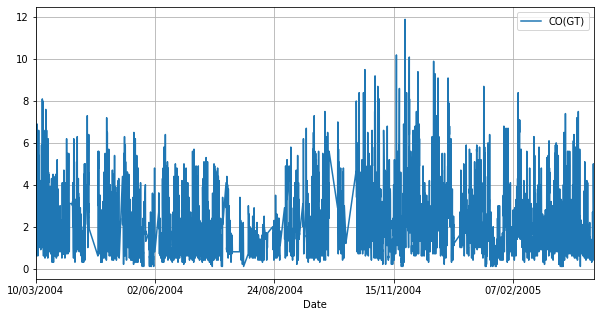

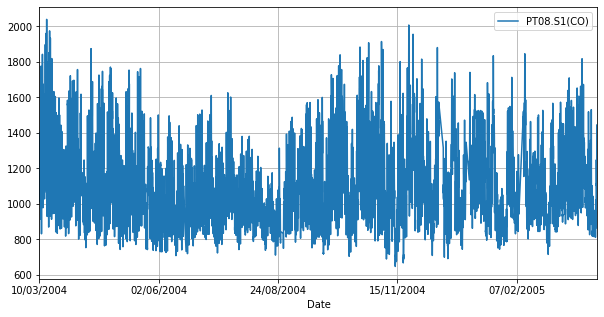

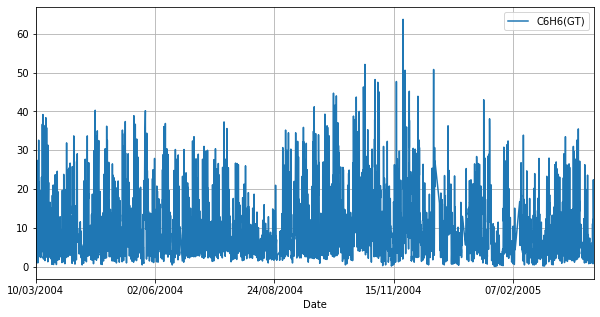

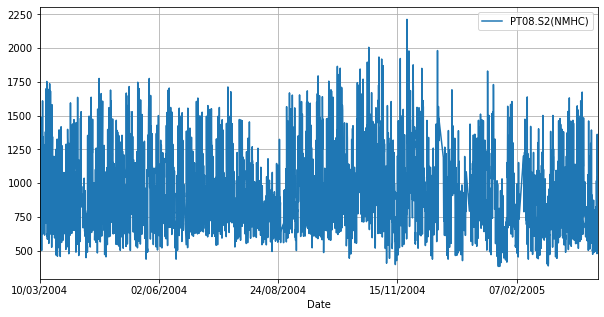

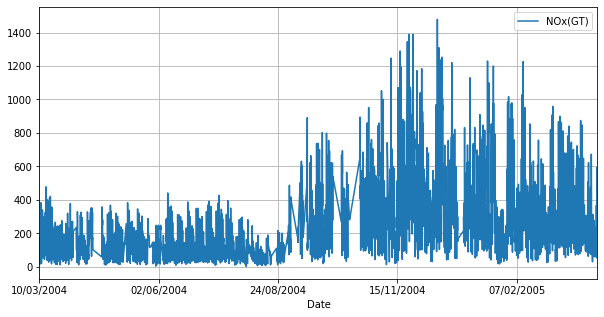

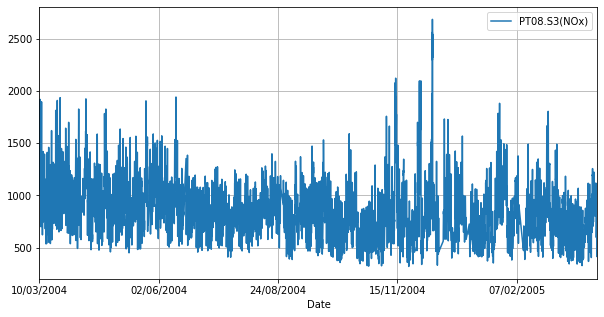

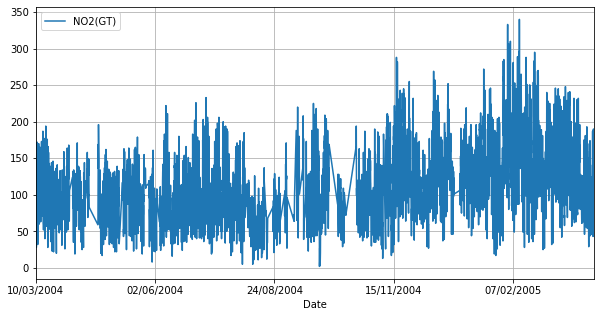

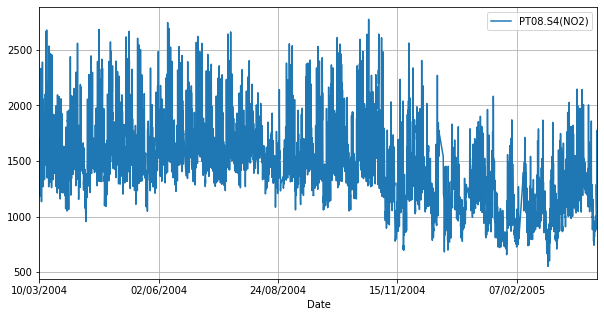

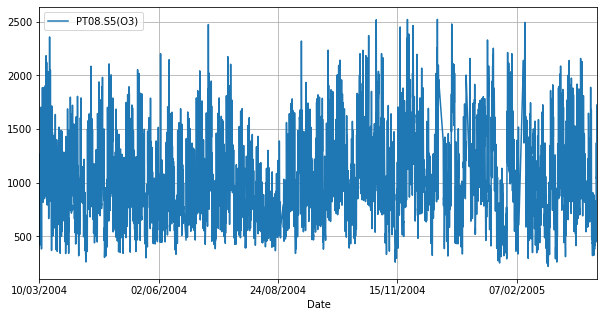

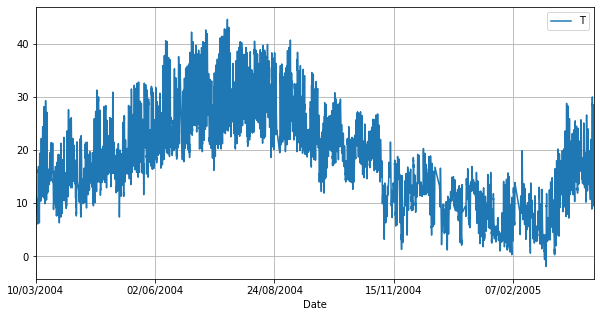

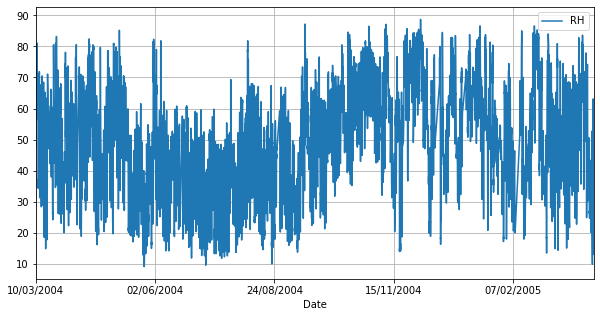

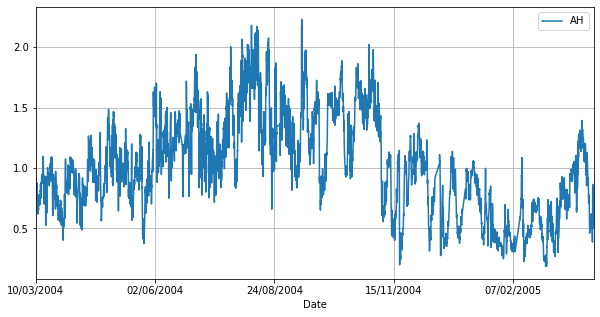

In [9]:
for name in col_names:
    data.plot(x='Date', y=name, figsize=(10, 5))
    plt.grid(True)
    plt.show()

In [10]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [11]:
def split_sequences(sequences, n_steps):
    X, y = list(), list()
    for i in range(len(sequences)):
        end_ix = i + n_steps
        if (end_ix > len(sequences)):
            break
        seq_x, seq_y = sequences[i:end_ix, :-1], sequences[end_ix-1, -1]
        X.append(seq_x)
        y.append(seq_y)
    return array(X), array(y)

In [12]:
data = data.drop(['Date', 'Time'], axis=1)

In [13]:
data = series_to_supervised(data, 1, 1)
data.head(5)

,var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var6(t-1),var7(t-1),var8(t-1),var9(t-1),var10(t-1),...,var3(t),var4(t),var5(t),var6(t),var7(t),var8(t),var9(t),var10(t),var11(t),var12(t)
1,2.6,1360.0,11.9,1046.0,166.0,1056.0,113.0,1692.0,1268.0,13.6,...,9.4,955.0,103.0,1174.0,92.0,1559.0,972.0,13.3,47.7,0.7255
2,2.0,1292.0,9.4,955.0,103.0,1174.0,92.0,1559.0,972.0,13.3,...,9.0,939.0,131.0,1140.0,114.0,1555.0,1074.0,11.9,54.0,0.7502
3,2.2,1402.0,9.0,939.0,131.0,1140.0,114.0,1555.0,1074.0,11.9,...,9.2,948.0,172.0,1092.0,122.0,1584.0,1203.0,11.0,60.0,0.7867
4,2.2,1376.0,9.2,948.0,172.0,1092.0,122.0,1584.0,1203.0,11.0,...,6.5,836.0,131.0,1205.0,116.0,1490.0,1110.0,11.2,59.6,0.7888
5,1.6,1272.0,6.5,836.0,131.0,1205.0,116.0,1490.0,1110.0,11.2,...,4.7,750.0,89.0,1337.0,96.0,1393.0,949.0,11.2,59.2,0.7848


In [14]:
cols = list(data.columns)

for i in cols:
    print(cols.index(i), i)

0 var1(t-1)
1 var2(t-1)
2 var3(t-1)
3 var4(t-1)
4 var5(t-1)
5 var6(t-1)
6 var7(t-1)
7 var8(t-1)
8 var9(t-1)
9 var10(t-1)
10 var11(t-1)
11 var12(t-1)
12 var1(t)
13 var2(t)
14 var3(t)
15 var4(t)
16 var5(t)
17 var6(t)
18 var7(t)
19 var8(t)
20 var9(t)
21 var10(t)
22 var11(t)
23 var12(t)


In [15]:
data.drop(data.columns[[12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22]], axis=1, inplace=True)
data.head(5)

,var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var6(t-1),var7(t-1),var8(t-1),var9(t-1),var10(t-1),var11(t-1),var12(t-1),var12(t)
1,2.6,1360.0,11.9,1046.0,166.0,1056.0,113.0,1692.0,1268.0,13.6,48.9,0.7578,0.7255
2,2.0,1292.0,9.4,955.0,103.0,1174.0,92.0,1559.0,972.0,13.3,47.7,0.7255,0.7502
3,2.2,1402.0,9.0,939.0,131.0,1140.0,114.0,1555.0,1074.0,11.9,54.0,0.7502,0.7867
4,2.2,1376.0,9.2,948.0,172.0,1092.0,122.0,1584.0,1203.0,11.0,60.0,0.7867,0.7888
5,1.6,1272.0,6.5,836.0,131.0,1205.0,116.0,1490.0,1110.0,11.2,59.6,0.7888,0.7848


In [16]:
names = [
    'var1(t-1)',
    'var2(t-1)',
    'var3(t-1)',
    'var4(t-1)',
    'var5(t-1)',
    'var6(t-1)',
    'var7(t-1)',
    'var8(t-1)',
    'var9(t-1)',
    'var10(t-1)',
    'var11(t-1)',
    'var12(t-1)',
    'var12(t)'
]

In [17]:
scaler = MinMaxScaler(feature_range=(0,1))
data = scaler.fit_transform(data)
data = pd.DataFrame(data, columns=names)
data.head(5)

,var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var6(t-1),var7(t-1),var8(t-1),var9(t-1),var10(t-1),var11(t-1),var12(t-1),var12(t)
0,0.211864,0.511845,0.185535,0.362097,0.111036,0.310885,0.328402,0.513040,0.454822,0.333333,0.499371,0.280066,0.264282
1,0.161017,0.463029,0.146226,0.312398,0.068382,0.360864,0.266272,0.453237,0.326238,0.326882,0.484277,0.264282,0.276352
2,0.177966,0.541996,0.139937,0.303659,0.087339,0.346463,0.331361,0.451439,0.370547,0.296774,0.563522,0.276352,0.294190
3,0.177966,0.523331,0.143082,0.308575,0.115098,0.326133,0.355030,0.464478,0.426586,0.277419,0.638994,0.294190,0.295216
4,0.127119,0.448672,0.100629,0.247406,0.087339,0.373994,0.337278,0.422212,0.386186,0.281720,0.633962,0.295216,0.293261


In [18]:
n_steps = 3

In [19]:
#x, y = split_sequences(data, n_steps)

In [20]:
#values = data.values

#n_train = 365*24

#train = values[:n_train]
#test = values[n_train:]

#x_train, y_train = train[:,:-1], train[:,-1]
#x_test, y_test = test[:,:-1], test[:,-1]

In [21]:
X = data.loc[:,[
    'var1(t-1)',
    'var2(t-1)',
    'var3(t-1)',
    'var4(t-1)',
    'var5(t-1)',
    'var6(t-1)',
    'var7(t-1)',
    'var8(t-1)',
    'var9(t-1)',
    'var10(t-1)',
    'var11(t-1)',
    'var12(t-1)',
]]

Y = data.loc[:,['var12(t)']]

In [22]:
print(X.shape, Y.shape)

(9356, 12) (9356, 1)


In [23]:
def split_data(x, y, train_size):
    x_train = x[:int(len(x)*train_size)]
    x_test = x[int(len(x)*train_size):]
    y_train = y[:int(len(y)*train_size)]
    y_test = y[int(len(y)*train_size):]
    return x_train, x_test, y_train, y_test

In [24]:
#X = np.reshape(X, (len(X), len(X[1]), 1))
x_train, x_test, y_train, y_test = split_data(X, Y, train_size=0.7)

In [25]:
print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)

(6549, 12) (2807, 12) (6549, 1) (2807, 1)


In [26]:
model = Sequential()
model.add(Conv1D(filters=10, kernel_size=2, activation='relu', input_shape=(12, 1)))
model.add(Conv1D(filters=10, kernel_size=2, activation='relu'))
model.add(MaxPooling1D(pool_size=2))

model.add(Flatten())
model.add(Dense(50, activation='relu'))
model.add(Dense(1))

W0627 15:34:43.423770 139914452637504 deprecation_wrapper.py:119] From /home/lucas/LICA/LICA/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0627 15:34:43.443909 139914452637504 deprecation_wrapper.py:119] From /home/lucas/LICA/LICA/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0627 15:34:43.450983 139914452637504 deprecation_wrapper.py:119] From /home/lucas/LICA/LICA/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0627 15:34:43.702388 139914452637504 deprecation_wrapper.py:119] From /home/lucas/LICA/LICA/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:3976: The name tf.nn.max_pool is deprecated. Please use tf.nn.max_pool2d instead.



In [27]:
model.compile(optimizer='adam', loss='mse')

W0627 15:34:43.769566 139914452637504 deprecation_wrapper.py:119] From /home/lucas/LICA/LICA/lib/python3.7/site-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.



In [28]:
X = np.expand_dims(X, axis=2)

In [29]:
print(X.shape)

(9356, 12, 1)


In [30]:
model.fit(X, Y, epochs=100, verbose=0)

W0627 15:34:44.250407 139914452637504 deprecation_wrapper.py:119] From /home/lucas/LICA/LICA/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:986: The name tf.assign_add is deprecated. Please use tf.compat.v1.assign_add instead.

W0627 15:34:44.368659 139914452637504 deprecation_wrapper.py:119] From /home/lucas/LICA/LICA/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:973: The name tf.assign is deprecated. Please use tf.compat.v1.assign instead.



In [31]:
x_test = np.expand_dims(x_test, axis=2)

In [32]:
pred = model.predict(x_test)

In [33]:
def MAPE(y_test, predict):
    soma = 0
    for i in range(len(y_test)):
        soma += abs((y_test[i] - predict[i]) / y_test[i]) * 100
    media_erro = soma / len(y_test)
    return media_erro.round(5)

In [34]:
from sklearn.metrics import mean_squared_error

print(np.sqrt(mean_squared_error(y_test, pred)).round(5))

0.01521


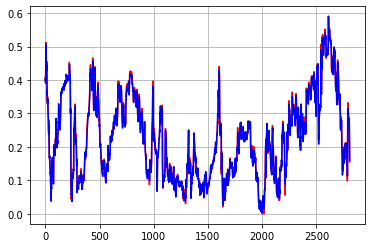

In [42]:
plt.plot(y_test.reset_index(drop=True), 'r')
plt.plot(pred, 'b')
plt.grid(True)